In [2]:
import pandas as pd 
import numpy as np 
# import dgl #deep graph network that will make integrating graphs easier
import torch
from scipy.spatial.distance import cdist
import torch.nn as nn 
import torch.nn.functional as F
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [3]:
signal_label = "QCD"
signal_label = "WJet"
props = ['pdgId']
data_dir = "/isilon/data/users/jpfeife2/AutoEncoder-Anomaly-Detection/processed_data"

batch_size = 20
epochs = 1
initial_lr = 0.001
weight_decay = 1e-3
latent_dim = 12

n_props = len(props)
n_props = 8

prop_string = ''.join(['_' + str(prop) for prop in props])

background_file = data_dir + "/background.pkl"
signal_file = data_dir + "/signal.pkl"

background = pd.read_pickle(background_file)
signal = pd.read_pickle(signal_file)

In [4]:
properties = ['pdgId']
data = background

In [5]:
hists = []
n_properties = len(properties)
for prop in properties: 
    if prop == 'pdgId': 
        flattened_list = [item for sublist in data['pdgId'] for item in sublist]
        unique_values_list = sorted(list(set(flattened_list)))
        print(unique_values_list)

[-211, -13, -11, 11, 13, 22, 130, 211]


In [5]:
data = signal
hists = []
n_properties = len(properties)
for prop in properties: 
    if prop == 'pdgId': 
        flattened_list = [item for sublist in data['pdgId'] for item in sublist]
        unique_values_list = sorted(list(set(flattened_list)))
        print(unique_values_list)

[-211, -13, -11, 11, 13, 22, 130, 211]


In [6]:
print(background['pdgId'][0])

[-211, 211, 130, 22, -211, 211, 22, 211, 130, -211, 22, 22, 211, 211, 211, -211, -211, 211, -211, 130]


In [7]:
from sklearn import preprocessing

In [8]:
background['d0']

0        [0.003107071, -0.0028095245, -1.0, -1.0, 0.004...
1        [0.00043153763, -0.0057754517, -0.0028514862, ...
2        [-0.024139404, -0.0071144104, 0.00013065338, -...
3        [-0.003786087, 0.0093688965, -0.016708374, -1....
4        [0.0009202957, 0.0072746277, 0.006214142, -0.0...
                               ...                        
78393    [-0.002111435, 0.0053901672, 0.0041275024, -1....
78394    [-1.0, -1.0, 0.00066423416, -0.14782715, -1.0,...
78395    [0.13745117, 0.008079529, 0.0020866394, -0.017...
78396    [-0.08898926, -0.018371582, 0.0013303757, -0.0...
78397    [0.0016899109, -0.0035686493, -0.0056991577, -...
Name: dz, Length: 78398, dtype: object

0.003107071


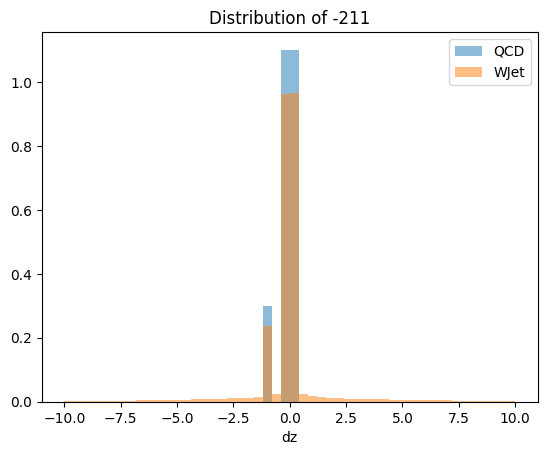

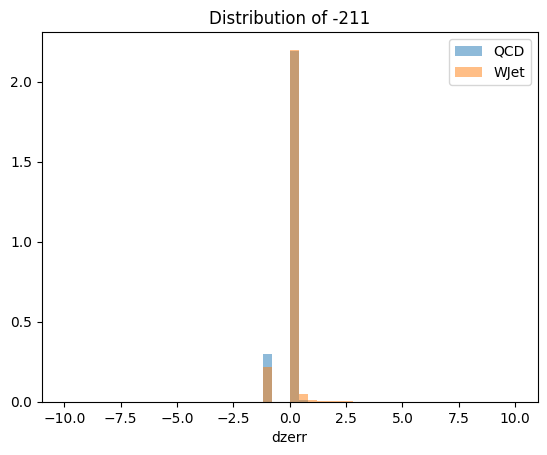

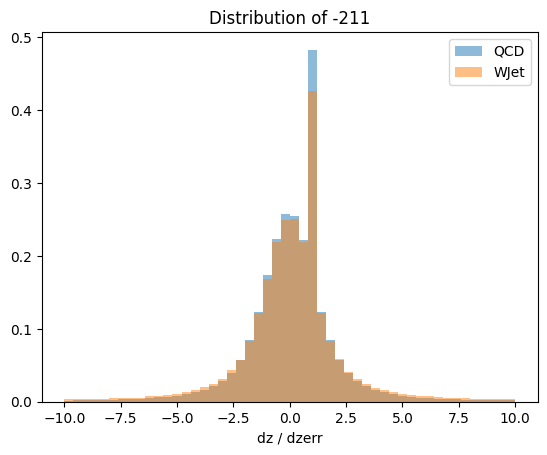

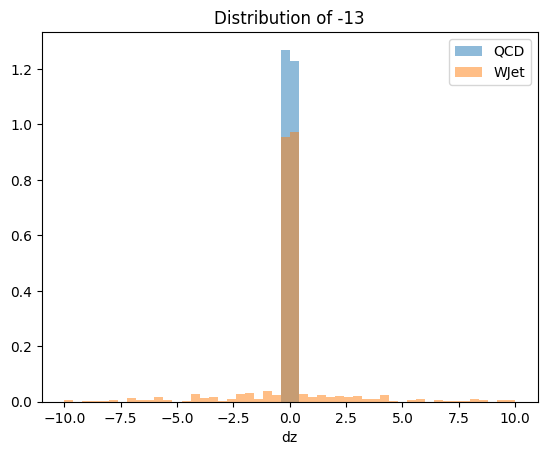

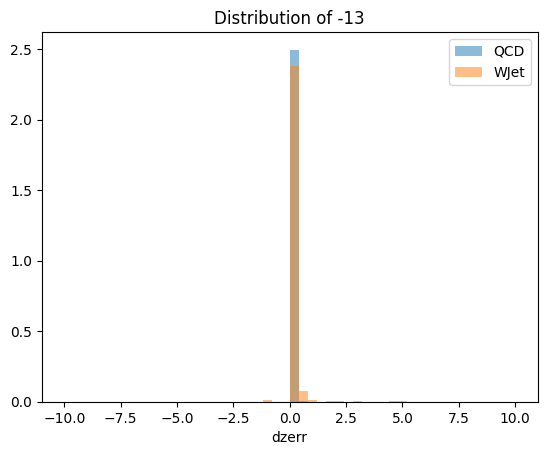

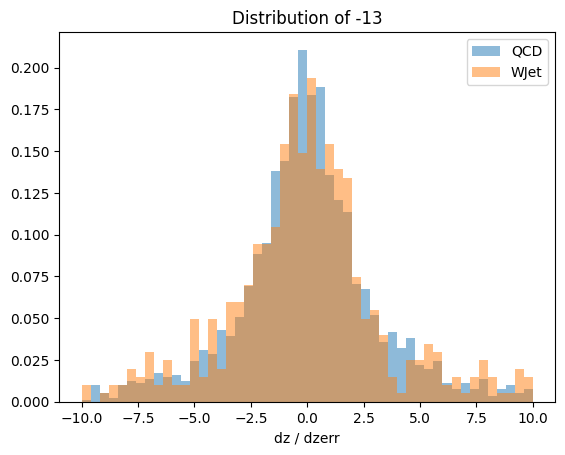

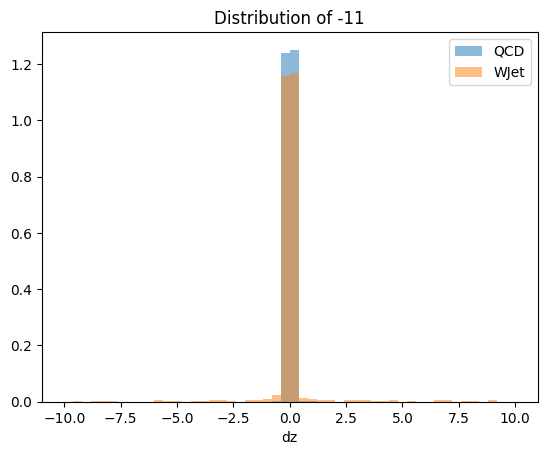

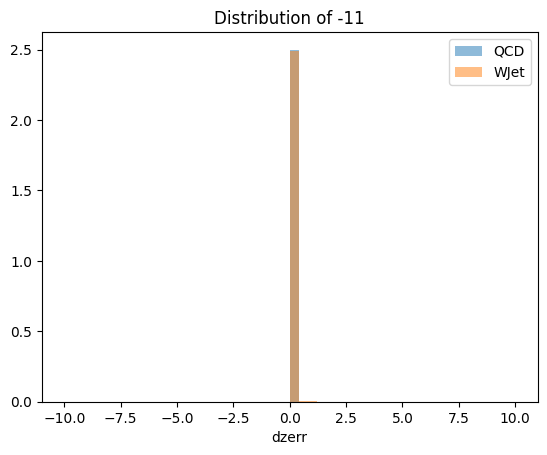

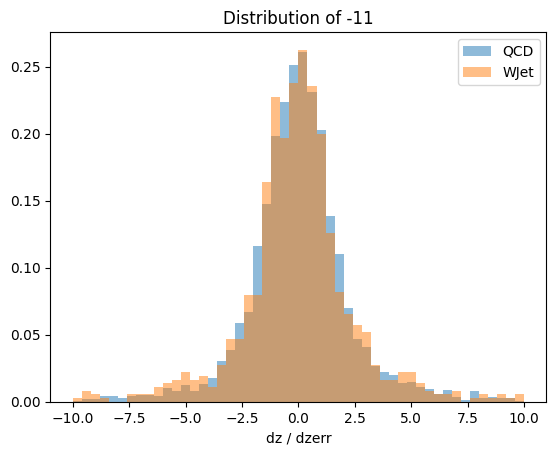

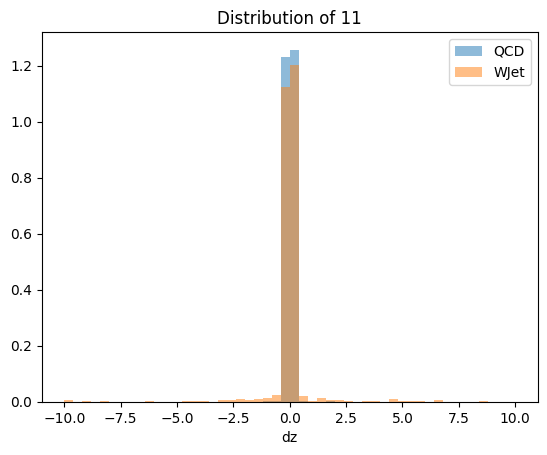

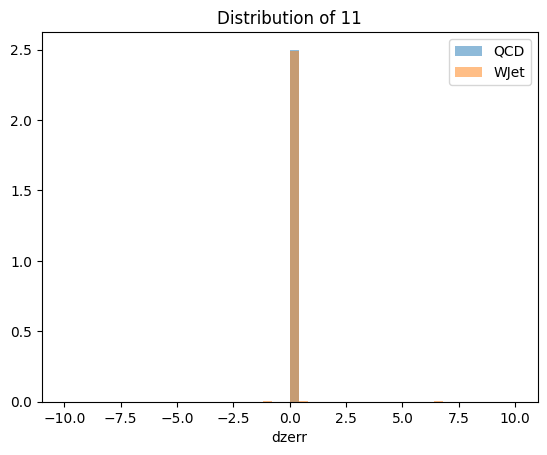

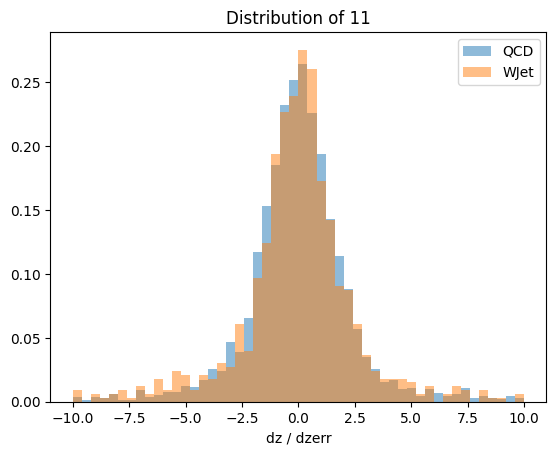

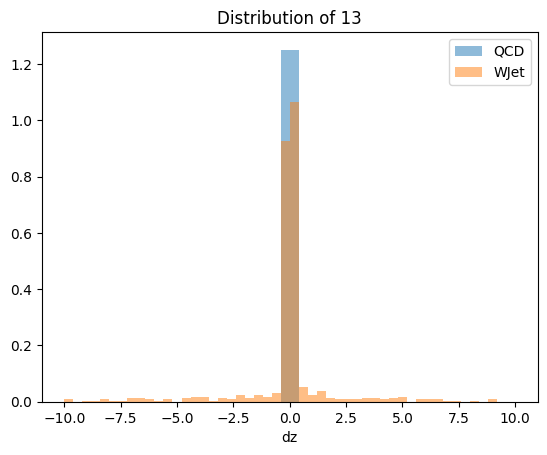

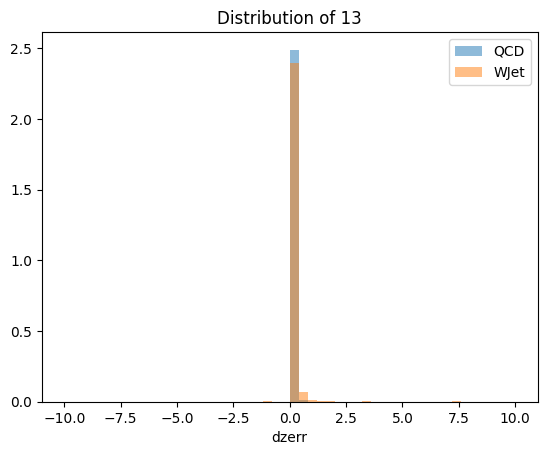

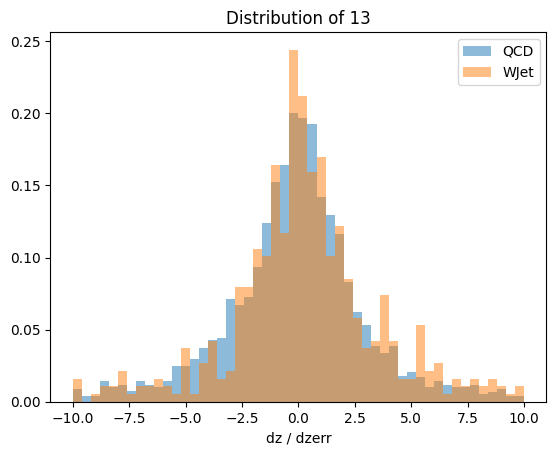

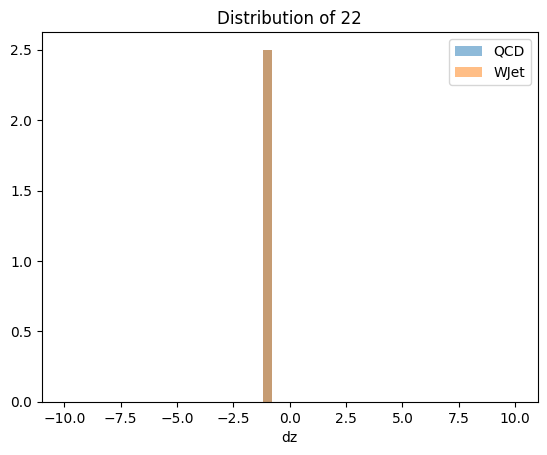

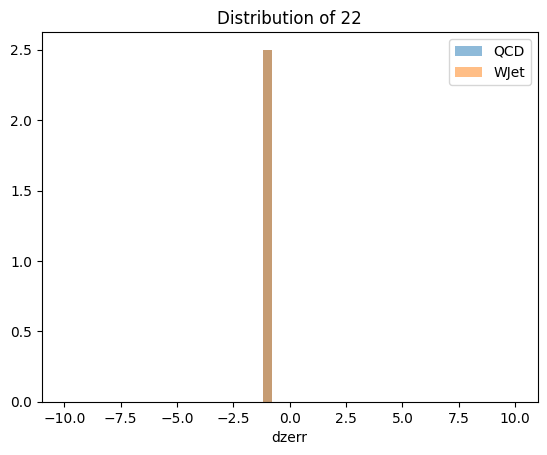

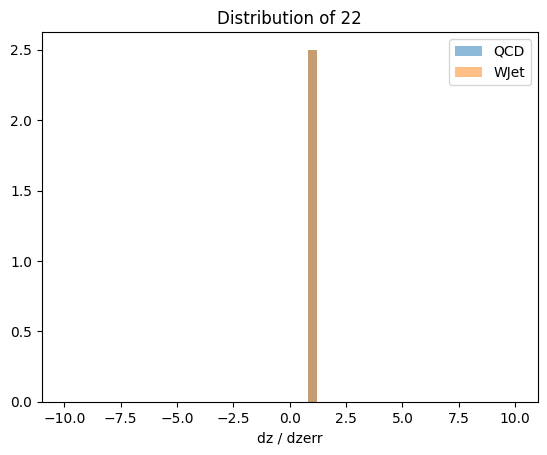

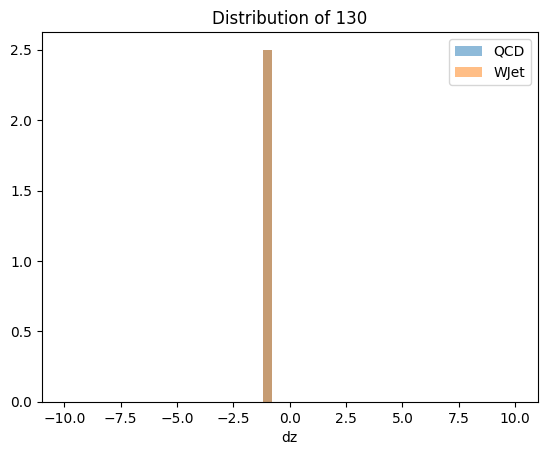

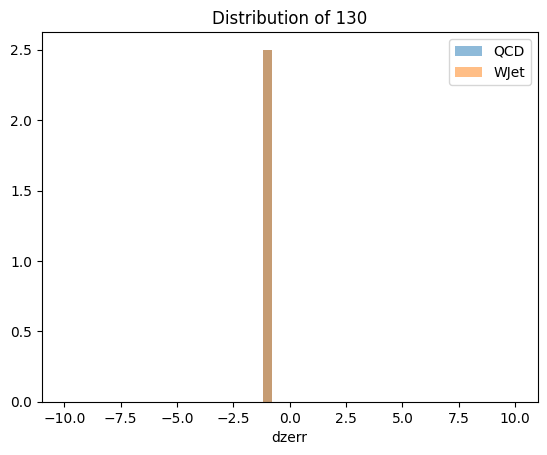

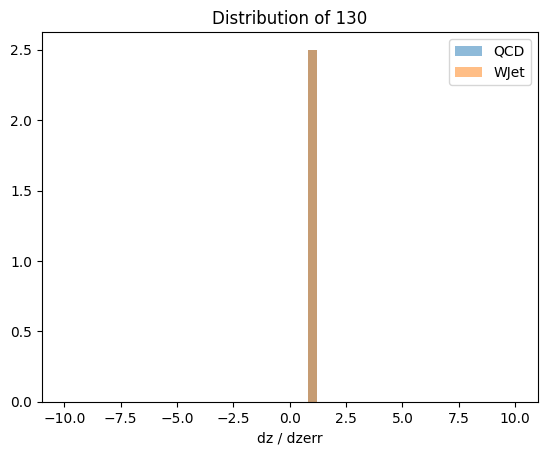

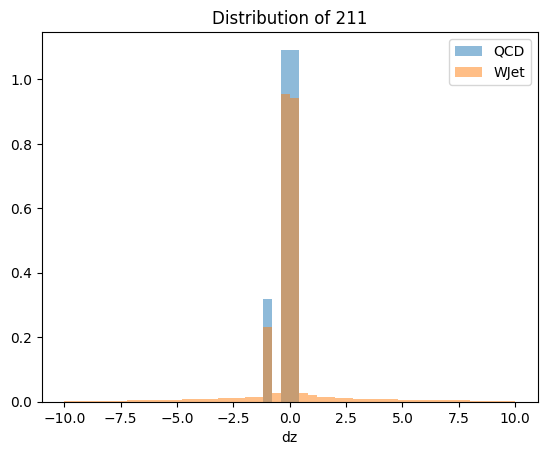

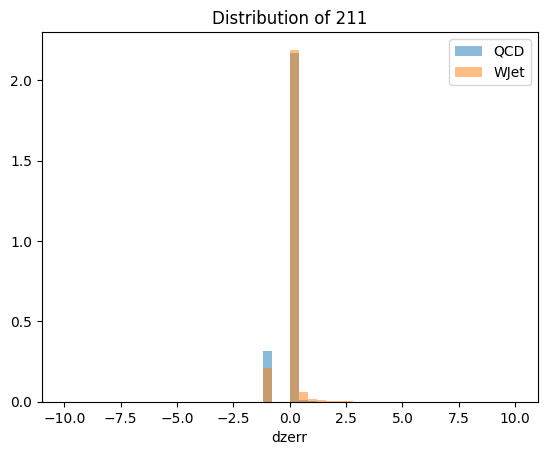

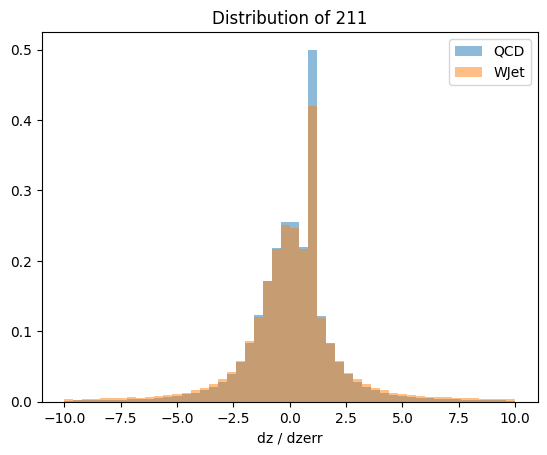

In [9]:
background_d0 = [p for sublist in background['d0'] for p in sublist]
print(background_d0[0])
signal_d0 = [p for sublist in signal['d0'] for p in sublist]
background_d0err = [p for sublist in background['d0Err'] for p in sublist]
signal_d0err = [p for sublist in signal['d0Err'] for p in sublist]
background_d0_d0err = [p / z for sublist1, sublist2 in zip(background['d0'], background['d0Err']) for p, z in zip(sublist1, sublist2)]
signal_d0_d0err = [p / z for sublist1, sublist2 in zip(signal['d0'], signal['d0Err']) for p, z in zip(sublist1, sublist2)]
background_prop = [p for sublist in background['pdgId'] for p in sublist]
signal_prop = [p for sublist in signal['pdgId'] for p in sublist]

scaler = preprocessing.StandardScaler().fit(np.array(background_d0_d0err).reshape(-1,1))
scaler = preprocessing.StandardScaler().fit(np.array(signal_d0_d0err).reshape(-1,1))

for idx, val in enumerate(unique_values_list): 
    try:
        background_indices = np.where(background_prop == val)[0]
        background_d02 = np.array(background_d0)[background_indices]
        within_3sigma_indices = np.abs(background_d02) <= 10
        background_d02 = background_d02[within_3sigma_indices].flatten()
        background_d0err2 = np.array(background_d0err)[background_indices][within_3sigma_indices].flatten()
        background_d0_d0err2 = np.array(background_d0_d0err)[background_indices][within_3sigma_indices].flatten()
        
        # d0err_pos = background_d0err2 >= 0 

        # background_d02 = background_d02[d0err_pos].flatten()
        # background_d0err2 = background_d0err2[d0err_pos].flatten()
        # background_d0_d0err2 = background_d0_d0err2[d0err_pos].flatten()

        scaler = preprocessing.StandardScaler().fit(np.array(background_d0_d0err2).reshape(-1,1))


        signal_indices = np.where(signal_prop == val)[0]
        signal_d02 = np.array(signal_d0)[signal_indices]
        within_3sigma_indices = np.abs(signal_d02) <= 10
        signal_d02 = signal_d02[within_3sigma_indices].flatten()
        signal_d0err2 = np.array(signal_d0err)[signal_indices][within_3sigma_indices].flatten()
        signal_d0_d0err2 = np.array(signal_d0_d0err)[signal_indices][within_3sigma_indices].flatten()

        # sd0err_pos = signal_d0err2 >= 0 

        # signal_d02 = signal_d02[sd0err_pos].flatten()
        # signal_d0err2 = signal_d0err2[sd0err_pos].flatten()
        # signal_d0_d0err2 = signal_d0_d0err2[sd0err_pos].flatten()

        bin_range = (-10, 10)

        fig, ax = plt.subplots()
        ax.set_title("Distribution of " + str(val) )
        ax.set_xlabel('d0')
        bins = 50
        ax.hist(background_d02, density=True, label='QCD', alpha=0.5, bins=bins, range = bin_range)
        ax.hist(signal_d02, density=True, label='WJet', alpha=0.5, bins=bins, range = bin_range)
        plt.legend()
        plt.savefig("plots/" + str(val) + "_d0_distribution.png")
        plt.show()
        plt.close(fig)

        fig, ax = plt.subplots()
        ax.set_title("Distribution of " + str(val) )
        ax.set_xlabel('d0err')
        bins = 50
        ax.hist(background_d0err2, density=True, label='QCD', alpha=0.5, bins=bins, range = bin_range)
        ax.hist(signal_d0err2, density=True, label='WJet', alpha=0.5, bins=bins, range = bin_range)
        plt.legend()
        plt.savefig("plots/" + str(val) + "_d0err_distribution.png")
        plt.show()
        plt.close(fig)

        fig, ax = plt.subplots()
        ax.set_title("Distribution of " + str(val) )
        ax.set_xlabel('d0 / d0err')
        bins = 50
        ax.hist(background_d0_d0err2, density=True, label='QCD', alpha=0.5, bins=bins, range = bin_range)
        ax.hist(signal_d0_d0err2, density=True, label='WJet', alpha=0.5, bins=bins, range = bin_range)
        plt.legend()
        plt.savefig("plots/" + str(val) + "_d0_d0err_distribution.png")
        plt.show()
        plt.close(fig)
    except: 
        print('error with', str(val))


[-211, 211, 130, 22, -211, 211, 22, 211, 130, -211, 22, 22, 211, 211, 211, -211, -211, 211, -211, 130, 211]
798784
798784
193439
193439


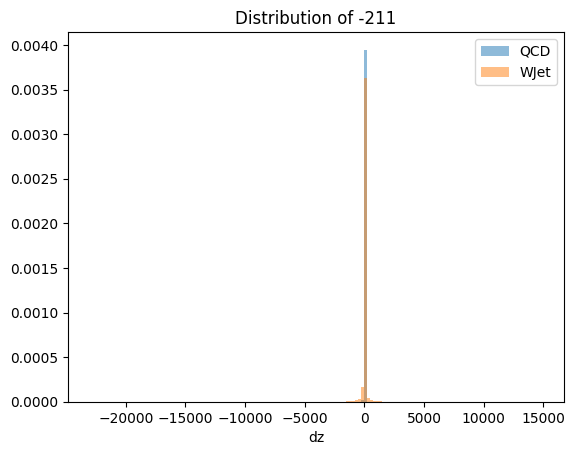

2227
2227
725
725


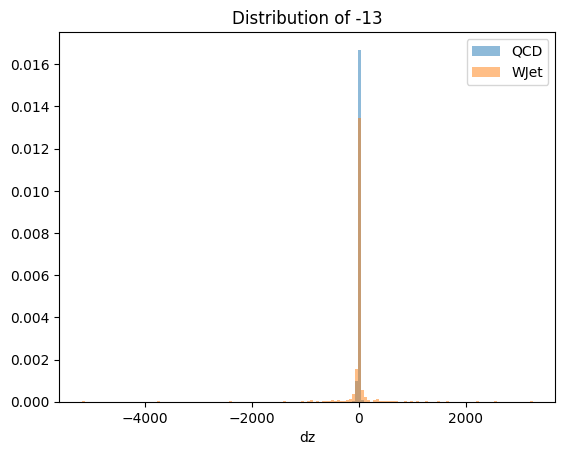

3443
3443
1036
1036


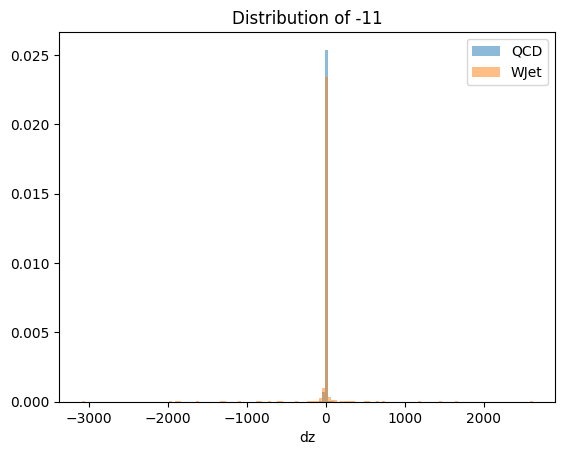

3365
3365
932
932


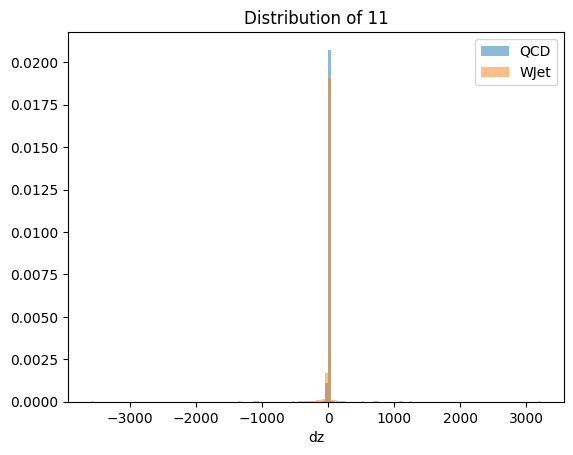

2136
2136
664
664


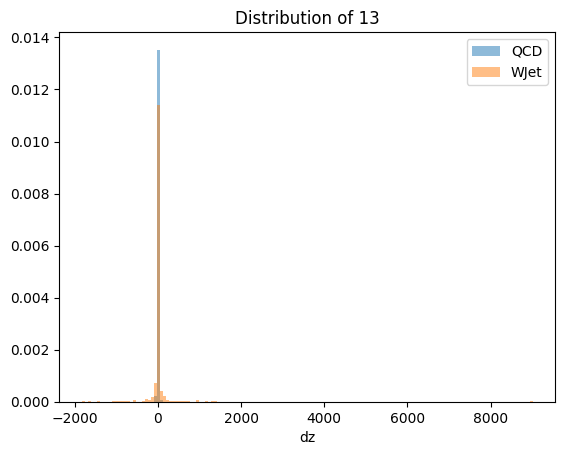

867664
867664
180697
180697


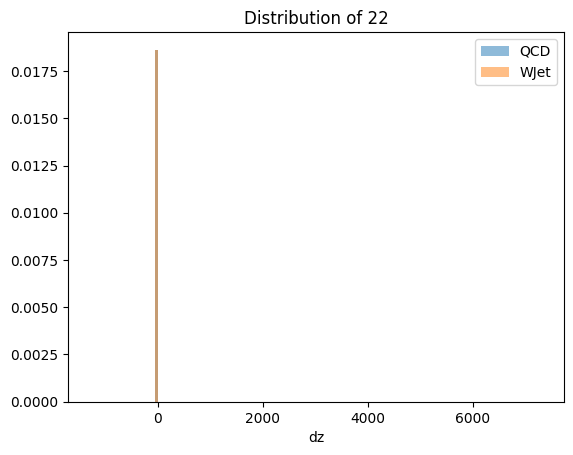

327811
327811
67007
67007


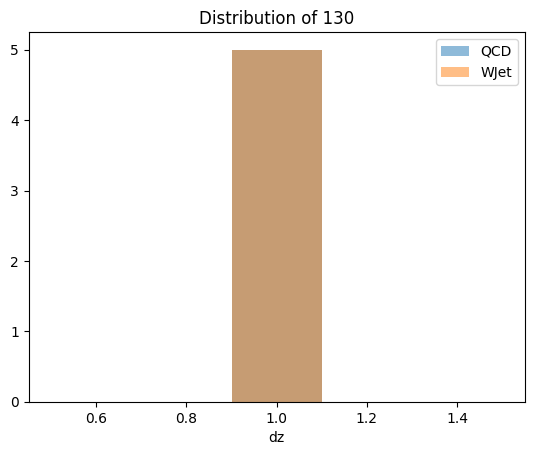

811014
811014
199438
199438


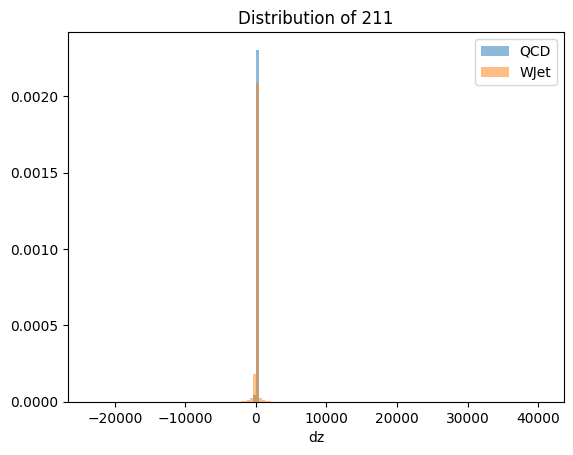

In [10]:
for prop_name in props: 
    background_prop = [p for sublist in background[prop_name] for p in sublist]
    signal_prop = [p for sublist in signal[prop_name] for p in sublist]

    print(background_prop[:21])
    for idx, val in enumerate(unique_values_list): 
        background_indices = np.where(background_prop == val)[0]
        background_d0 = [p / z for sublist1, sublist2 in zip(background['d0'], background['d0Err']) for p, z in zip(sublist1, sublist2)]
        background_d0 = np.array(background_d0)[background_indices]
        
        print(len(background_indices))
        print(len(background_d0))

        signal_indices = np.where(signal_prop == val)[0]
        signal_d0 = [p / z for sublist1, sublist2 in zip(signal['d0'], signal['d0Err']) for p, z in zip(sublist1, sublist2)]
        signal_d0 = np.array(signal_d0)[signal_indices]
        print(len(signal_indices))
        print(len(signal_d0))

        fig, ax = plt.subplots()
        ax.set_title("Distribution of " + str(val) )
        ax.set_xlabel('d0')

        num_unique = len(np.unique(np.concatenate([background_d0, signal_d0])))
        if num_unique < 50: 
            bins = num_unique * 5
        else: 
            bins = 150

        bin_range = (np.min([np.min(background_d0), np.min(signal_d0)]),
                np.max([np.max(background_d0), np.max(signal_d0)]))

        if not np.isinf(np.min([np.min(background_d0), np.min(signal_d0)])): 
            if not np.isinf(np.max([np.max(background_d0), np.max(signal_d0)])):
                ax.hist(background_d0, density=True, label='QCD', alpha=0.5, bins=bins, range = bin_range)
                ax.hist(signal_d0, density=True, label='WJet', alpha=0.5, bins=bins, range = bin_range)
                plt.legend()
                # plt.xlim(-2, 2)
                plt.savefig("plots/" + str(val) + "_d0_distribution.png")
                plt.show()
                plt.close(fig)



In [11]:
background_prop = [p for sublist in background['d0'] for p in sublist]
values = set(sorted(np.unique(background_prop)))
print(values)

{-0.9970703, -0.93115234, -0.8833008, -0.72998047, -0.71240234, -0.6972656, -0.6591797, -0.6147461, -0.6015625, -0.59521484, -0.5185547, -0.5102539, -0.46728516, -0.46606445, -0.46484375, -0.45410156, 0.001326561, 3.0605469, 9.5390625, 10.296875, 4.1171875, 0.027175903, -0.002861023, -0.0016031265, -0.0011148453, -0.00013828278, -6.8061054e-06, -5.375594e-06, -4.8987567e-06, -0.0040740967, -0.00017619133, 0.00031208992, 0.024749756, 4.017353e-05, 0.00016224384, 0.000223279, -2.0861626e-05, -0.030075073, -0.014450073, -0.028121948, -0.012496948, -0.026168823, -0.010543823, -0.024215698, -0.008590698, -0.022262573, -0.0066375732, 0.022323608, -0.04260254, 0.019897461, 0.08239746, 0.14489746, 0.20739746, 0.30932617, 0.0010232925, 0.017471313, -0.13012695, -0.024536133, -0.019683838, -0.029388428, -0.014831543, -0.034240723, -0.039093018, -0.027511597, -0.043945312, -0.023605347, 0.00094747543, -0.047454834, 0.015045166, 9.173155e-05, 0.013832092, 0.0008716583, 0.0028247833, 0.012619019, 0

In [12]:
background_prop = [p for sublist in background['d0Err'] for p in sublist]
values = set(sorted(np.unique(background_prop)))
print(values)

{0.0006451607, 0.00066518784, 0.00068950653, 0.00066947937, 0.0006933212, 0.00070619583, 0.0007081032, 0.00070905685, 0.0007162094, 0.0007176399, 0.00071811676, 0.0007185936, 0.00072336197, 0.0007238388, 0.00072574615, 0.0007324219, 0.0018148422, 2.0019531, 2.0039062, 2.0058594, 2.0078125, 3.0078125, 3.0175781, 3.0234375, 0.027175903, 0.5810547, 4.015625, 4.0234375, 4.0625, 4.0898438, 4.125, 0.0010824203, 0.0012044907, 0.001326561, 0.0014486313, 0.0015707016, 0.00434494, 0.0037384033, 0.0076446533, 0.011550903, 0.015457153, 7.203125, 7.2265625, 7.3125, 8.03125, 8.40625, 8.796875, 0.024749756, 0.040374756, 0.055999756, 0.50341797, 2.0097656, 2.015625, 1.5605469, 2.0175781, 2.0195312, 2.0234375, 12.3828125, 12.4609375, 12.953125, 14.1953125, 0.4645996, 0.0021514893, 0.0041046143, 0.008010864, 0.011917114, 0.015823364, 0.019729614, 0.0045928955, 0.0084991455, 0.0124053955, 0.016311646, 3.0253906, 3.0273438, 3.0332031, 3.0351562, 0.42578125, 0.92578125, 0.3869629, 4.1757812, 4.203125, 4.25

In [13]:
from fast_histogram import histogram2d
ETA_MIN = -0.8 
ETA_MAX = 0.8 
PHI_MIN = -0.8 
PHI_MAX = 0.8 
INCR = 0.05 
BINS = int(abs(ETA_MIN - ETA_MAX)/INCR)

def make_histogram(eta, phi, cc):
    hist_range = [[ETA_MIN, ETA_MAX], [PHI_MIN, PHI_MAX]]
    eta_bins = np.arange(ETA_MIN, ETA_MAX, INCR)
    phi_bins = np.arange(PHI_MIN, PHI_MAX, INCR)
    image_shape = (eta_bins.shape[0], phi_bins.shape[0])

    return histogram2d(phi, eta, range=hist_range, bins=image_shape, weights=cc)

In [14]:
data = background 

In [15]:
hists = []

In [16]:
d0 = [p / z for sublist1, sublist2 in zip(data['d0'], data['d0Err']) for p, z in zip(sublist1, sublist2)]
scaler = preprocessing.StandardScaler().fit(np.array(d0).reshape(-1,1))
hist_list = [] 

for i in range(data.shape[0]):
        prop_data = pd.to_numeric(data['d0'][i])/pd.to_numeric(data['d0Err'][i])
        valid_indices = np.array(data['d0Err'][i]) >= 0 
        prop_data = np.array(prop_data)[valid_indices]

        try: 
            d0_scaled = scaler.transform(prop_data.reshape(-1,1))
            within_3sigma_indices = (np.abs(d0_scaled) <= 3).flatten()
            filtered_eta = np.array(data['eta'][i])[valid_indices][within_3sigma_indices].flatten()
            filtered_phi = np.array(data['phi'][i])[valid_indices][within_3sigma_indices].flatten()
            filtered_d0 = np.array(d0_scaled)[within_3sigma_indices].flatten()
            hist_list.append(make_histogram(filtered_eta, filtered_phi, filtered_d0*10))
        except: 
            d0_scaled = np.zeros(prop_data)
            print('error')
            hist_list.append(make_histogram([0], [0], [0]))

        

In [4]:
valid_pdg = [-11, 11, -13, 13, -211, 211]

In [18]:
print(len(background['']))

KeyError: ''

In [ ]:
print(len((background['d0Err'][0])))

20


In [11]:
d0 = [p / z for sublist1, sublist2, sublist3 in zip(background['d0'], background['d0Err'], background['pdgId']) for p, z, x in zip(sublist1, sublist2, sublist3) if z >=0 and x in valid_pdg and np.abs(p / z) <=5.0]
scaler = preprocessing.StandardScaler().fit(np.array(d0).reshape(-1,1))
d0 = scaler.transform(np.array(d0).reshape(-1,1))



In [12]:
pt = [p*10 for sublist in background['pt'] for p in sublist]
# scaler = preprocessing.StandardScaler(with_mean=False).fit(np.array(pt).reshape(-1,1))
# pt = scaler.transform(np.array(pt).reshape(-1,1))

In [13]:
spt = [p*10 for sublist in signal['pt'] for p in sublist]
# scaler = preprocessing.StandardScaler(with_mean=False).fit(np.array(spt).reshape(-1,1))
# spt = scaler.transform(np.array(spt).reshape(-1,1))

In [14]:
sd0 = [p / z for sublist1, sublist2, sublist3 in zip(signal['d0'], signal['d0Err'], signal['pdgId']) for p, z, x in zip(sublist1, sublist2, sublist3) if z >=0 and x in valid_pdg and np.abs(p / z) <=5.0]
# scaler = preprocessing.StandardScaler().fit(np.array(sd0).reshape(-1,1))
sd0 = scaler.transform(np.array(sd0).reshape(-1,1))



# hists = []
# hists.append([make_histogram(data['eta'][i], data['phi'][i], (np.array(data['pt'][i]) * 1).flatten()) for i in range(data.shape[0])])


In [15]:
background_prop = d0
signal_prop = sd0

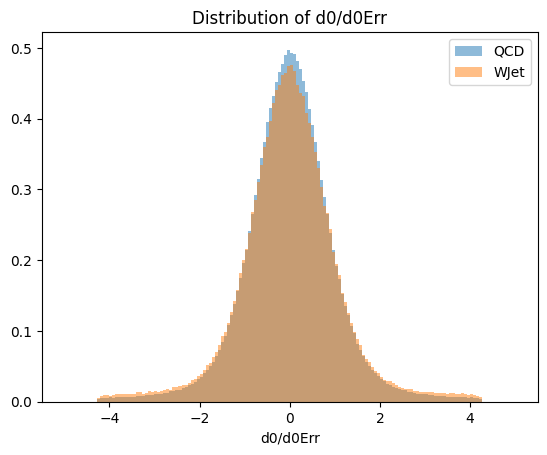

In [16]:
fig, ax = plt.subplots()
ax.set_title("Distribution of d0/d0Err" )
ax.set_xlabel("d0/d0Err")
# background_prop = background_prop[np.abs(background_prop) <= 20]
# signal_prop = signal_prop[np.abs(signal_prop) <= 20]

# num_unique = len(np.unique(np.concatenate([background_prop, signal_prop])))

bins = 150
bin_range = (-5,5)

ax.hist(background_prop, density=True, label='QCD', alpha=0.5, bins=bins, range=bin_range)
ax.hist(signal_prop, density=True, label='WJet', alpha=0.5, bins=bins, range=bin_range)
plt.legend()
# plt.yscale('log')
plt.savefig("plots/" + "d0_distribution.png")
plt.show()
plt.close(fig)

In [79]:
print(np.min(sd0))

-3.164462


: 

In [64]:
print(np.mean(sd0))
print(np.mean(d0))
print(np.std(d0))
print(np.std(sd0))

0.0057479753
-3.8238355e-09
1.0
1.7205969
